# Introductory applied machine learning (INFR10069) 

# Lab 2: Decision trees and linear regression

In the first part of this lab we perform Decision trees classification on the [German credit](http://archive.ics.uci.edu/ml/datasets/Statlog+%28German+Credit+Data%29) data set. In the second part we learn how to train simple linear regression model by using the [CPU performance](https://archive.ics.uci.edu/ml/datasets/Computer+Hardware) data set. Both datasets (`credit.csv` and `cpu.csv`) are located within the `datasets` directory (adjacent to this file).

As always, first activate the python environment if not already done so (remember to exclude 'source' if you're on windows):

```{bash}
source activate py3iaml
```

Now let's import the packages (*This will generate some warnings related to the libraries: ignore*):

In [1]:
# Import packages
import os
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import graphviz
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, r2_score
%matplotlib inline

C:\Users\larsw\anaconda3\envs\py3iaml\lib\site-packages\sklearn\utils\__init__.py:4: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Sequence
C:\Users\larsw\anaconda3\envs\py3iaml\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


## 1. Decision Trees
One of the great advantages of decision trees is their interpretability. The rules learnt for classification are easy for a person to follow, unlike the opaque "black box" of many other methods, such as neural networks. We demonstrate the utility of this using a German credit data set. You can read a description of this dataset at the [UCI site](http://archive.ics.uci.edu/ml/datasets/Statlog+%28German+Credit+Data%29). The task is to predict whether a loan approval is good or bad credit risk based on 20 attributes. We've simplified the data set somewhat, particularly making attribute names and values more meaningful.

We will load the credit dataset into a pandas DataFrame structure. 

In [2]:
# Load the dataset
data_path = os.path.join(os.getcwd(), 'datasets', 'credit.csv')
credit = pd.read_csv(data_path, delimiter = ',')

### ========== Question 1.1 ==========
Display the number of data points and attributes in the dataset. 

In [3]:
print(len(credit))
print(len(credit.columns))

1001
21


### ========== Question 1.2 ==========
Get a feeling of the data by using pandas `describe()` method. Be careful - there is a mixture of numeric and categorical data and hence will need to output it in two stages:

In [4]:
# Output Numeric Data
credit.describe(include=np.number)

,Duration,CreditAmount,InstallmentRate,ResidentSince,Age,NumCreditsAtBank,Dependents
count,1001.000000,1.001000e+03,1001.000000,1001.000000,1001.000000,1001.000000,1001.000000
mean,20.882118,-9.957330e+05,-7.019980,2.842158,35.217782,0.406593,0.969031
std,12.070878,3.160708e+07,316.165715,1.106825,15.398264,31.656714,5.894916
min,0.000000,-1.000000e+09,-10000.000000,0.000000,-293.000000,-1000.000000,-185.000000
25%,12.000000,1.364000e+03,2.000000,2.000000,27.000000,1.000000,1.000000
50%,18.000000,2.319000e+03,3.000000,3.000000,33.000000,1.000000,1.000000
75%,24.000000,3.972000e+03,4.000000,4.000000,42.000000,2.000000,1.000000
max,72.000000,1.842400e+04,4.000000,4.000000,75.000000,4.000000,2.000000


In [5]:
# Output Categorical Data
credit.describe(include=np.object)

,CheckingAccount,CreditHistory,Purpose,SavingsAccount,YearsEmployed,PersonalStatus,OtherDebtors,Property,OtherPlans,Housing,Job,Telephone,Foreign,Approve
count,1001,1001,1001,1001,1001,1001,1001,1001,1001,1001,1001,1001,1001,1001
unique,4,5,10,5,5,5,3,4,3,3,4,2,2,2
top,none,ok_til_now,television,<100,<4,male_single,none,car,none,own,skilled,no,yes,good
freq,394,530,280,603,339,548,908,333,815,714,631,596,963,701


### ========== Question 1.3 ==========
Display the first 10 data points of the dataset

*TIP*: You may need to set the option to display all columns: look at [pandas.set_option](https://pandas.pydata.org/pandas-docs/version/0.23.4/generated/pandas.set_option.html).

In [6]:
credit.head()

,CheckingAccount,Duration,CreditHistory,Purpose,CreditAmount,SavingsAccount,YearsEmployed,InstallmentRate,PersonalStatus,OtherDebtors,...,Property,Age,OtherPlans,Housing,NumCreditsAtBank,Job,Dependents,Telephone,Foreign,Approve
0,<0,0.0,ok,furniture,-1.000000e+09,unknown,unemployed,-10000.0,female_single,none,...,car,-293.0,none,own,-1000.0,skilled,-185.0,yes,no,good
1,<0,6.0,critical,television,1.169000e+03,unknown,>=7,4.0,male_single,none,...,real_estate,67.0,none,own,2.0,skilled,1.0,yes,yes,good
2,<200,48.0,ok_til_now,television,5.951000e+03,<100,<4,2.0,female,none,...,real_estate,22.0,none,own,1.0,skilled,1.0,no,yes,bad
3,none,12.0,critical,education,2.096000e+03,<100,<7,2.0,male_single,none,...,real_estate,49.0,none,own,1.0,unskilled,2.0,no,yes,good
4,<0,42.0,ok_til_now,furniture,7.882000e+03,<100,<7,2.0,male_single,guarantor,...,savings,45.0,none,free,1.0,skilled,2.0,no,yes,good


### ========== Question 1.4 ==========
When presented with a dataset, it is usually a good idea to visualise it first. By using seaborn's [pairplot](https://seaborn.github.io/generated/seaborn.pairplot.html?highlight=pairplot#seaborn.pairplot) function, try visualising a scatter plot of the `Age` and `Duration` variables. You can use the `Approve` variable as the `hue` parameter to visualise results separately for each class. Do you notice anything unusual?

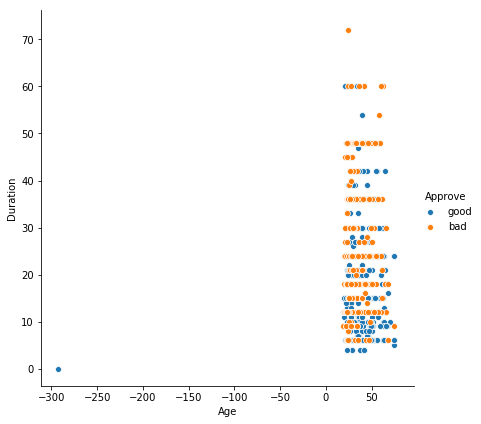

In [7]:
sns.pairplot(credit, hue="Approve", x_vars="Age", y_vars="Duration", height=6)
plt.show()

There is clearly an outlier that we want to exclude. No person in a credit dataset should have an age of -300 years.

### ========== Question 1.5 ==========
In the previous point you should have found a data point, which seems to be corrupted, as some of its values are nonsensical. Even a single point like this can significantly affect the performance of a classifier. How do you think it would affect Decision trees? How about Naive Bayes? A good way to check this is to test the performance of each classifier before and after removing this datapoint.

***Your answer goes here:***

With Decision Trees, things aren't so bad. Having this outlier would introduce a slight bias, but chances are it wouldn't affect many splits in a decisive way.

With Naive Bayes however, things would be quite bad. Trying to fit a normal distribution to the values of the Age parameter would not be easy, because for any sensible fit to the "real" data, the probability of the outlier occurring would be infinitesimally small. Therefore, the according Bell curve would probably shift to the left by a noticeable amount, which could affect our future classifications in a negative way.   

### ========== Question 1.6 ==========
Now we want to remove this instance from the dataset by using a filter. In general, we want to remove all instances, where the age of an applicant is lower than 0 years, as this suggests that the instance is corrupted. Use logical indexing to get rid of these instances without creating a new dataframe. Display the number of data points after any outliers have been removed.

In [8]:
credit = credit.loc[credit["Age"] >= 0]
print(len(credit))

1000


## Categorical Data and Encoding

### ========== Question 1.7 ==========

You might have noticed that most of the attributes in the dataset are in fact discrete. Now we want to know which variables exactly are discrete (both categorical and numerical, look [here](http://stats.stackexchange.com/questions/206/what-is-the-difference-between-discrete-data-and-continuous-data) if you are unsure about the difference) and which are continuous variables. In order to do so, we will inspect the number of possible values that each attribute can take. 

Display the number of values each attributes takes in the dataset. *Hint: As a first step, you want to loop over the columns of the DataFrame. Then you might find the numpy `unique` function quite useful.*

In [9]:
for col in credit.columns:
    print(col, len(np.unique(credit[col])))

CheckingAccount 4
Duration 33
CreditHistory 5
Purpose 10
CreditAmount 921
SavingsAccount 5
YearsEmployed 5
InstallmentRate 4
PersonalStatus 4
OtherDebtors 3
ResidentSince 4
Property 4
Age 53
OtherPlans 3
Housing 3
NumCreditsAtBank 4
Job 4
Dependents 2
Telephone 2
Foreign 2
Approve 2


It seems like the variables `Duration`, `CreditAmount` and `Age` are continuous and all the rest are discrete. The discrete variables are not in a very convenient format though. Ideally we would want the discrete attributes to take values between `0` and `n_values-1`. Pandas has a handy way of dealing with [Categorical](https://pandas.pydata.org/pandas-docs/version/0.23.4/categorical.html) data, which you are encouraged to get familiar with.

We will create a new DataFrame called `credit_clean` and convert all the discrete variables from `credit` into pandas Categorical types. Remember, we want to change the discrete variables only, so we will have to exclude the `CreditAmount`, `Age` and `Duration` attributes. Also, we don't really mind if the target variable is categorical, so we won't be transforming the `Approve` attribute either. Execute the cell below and make sure you understand what it does.

In [26]:
credit_clean = credit.copy(deep=True) # Make a copy of the DataFrame
for column in credit_clean.columns:   
    if column not in ['CreditAmount', 'Age', 'Duration', 'Approve']: # Exclude non discrete columns and the target
        credit_clean[column] = credit_clean[column].astype('category') # Convert using astype(...) method

### ========== Question 1.8 ==========
Display the first 10 data points of the clean data. Does it look like what you expected?

In [32]:
credit_clean.head(10)

,CheckingAccount,Duration,CreditHistory,Purpose,CreditAmount,SavingsAccount,YearsEmployed,InstallmentRate,PersonalStatus,OtherDebtors,...,Property,Age,OtherPlans,Housing,NumCreditsAtBank,Job,Dependents,Telephone,Foreign,Approve
1,<0,6.0,critical,television,1169.0,unknown,>=7,4.0,male_single,none,...,real_estate,67.0,none,own,2.0,skilled,1.0,yes,yes,good
2,<200,48.0,ok_til_now,television,5951.0,<100,<4,2.0,female,none,...,real_estate,22.0,none,own,1.0,skilled,1.0,no,yes,bad
3,none,12.0,critical,education,2096.0,<100,<7,2.0,male_single,none,...,real_estate,49.0,none,own,1.0,unskilled,2.0,no,yes,good
4,<0,42.0,ok_til_now,furniture,7882.0,<100,<7,2.0,male_single,guarantor,...,savings,45.0,none,free,1.0,skilled,2.0,no,yes,good
5,<0,24.0,past_delays,car_new,4870.0,<100,<4,3.0,male_single,none,...,unknown,53.0,none,free,2.0,skilled,2.0,no,yes,bad
6,none,36.0,ok_til_now,education,9055.0,unknown,<4,2.0,male_single,none,...,unknown,35.0,none,free,1.0,unskilled,2.0,yes,yes,good
7,none,24.0,ok_til_now,furniture,2835.0,<1000,>=7,3.0,male_single,none,...,savings,53.0,none,own,1.0,skilled,1.0,no,yes,good
8,<200,36.0,ok_til_now,car_used,6948.0,<100,<4,2.0,male_single,none,...,car,35.0,none,rent,1.0,management,1.0,yes,yes,good
9,none,12.0,ok_til_now,television,3059.0,>=1000,<7,2.0,male_divorced,none,...,real_estate,61.0,none,own,1.0,unskilled,1.0,no,yes,good
10,<200,30.0,critical,car_new,5234.0,<100,unemployed,4.0,male_married,none,...,car,28.0,none,own,2.0,management,1.0,no,yes,bad


### ========== Question 1.9 ==========

There is a **conceptual** problem with using an (unordered) categorical input to train a decision tree. Can you figure it out? *Hint*: Look at the data-types supported by the `DecisionTreeClassifier`, specifically the input to the [fit](http://scikit-learn.org/0.19/modules/generated/sklearn.tree.DecisionTreeClassifier.html#sklearn.tree.DecisionTreeClassifier.fit) method.

***Your answer goes here:***

Input data to the fit method is converted to float internally. The conceptual problem is then that the algorithm will assume that the categories are ordered, which will affect the judgement of the algorithm in unwanted ways. The algorithm cannot draw a boundary between 2 categorical values without drawing a line between the categories to its' "left and right" at the same time.

### ========== Question 1.10 ==========

Let us then convert the categorical values we just created into a one-hot-encoding. Pandas provides this functionality conveniently via the [`get_dummies`](https://pandas.pydata.org/pandas-docs/version/0.23.4/generated/pandas.get_dummies.html) method. Use it to generate a matrix `X` containing the one-hot encoded categorical features as well as the floating-point attributes (`CreditAmount`, `Age` and `Duration`). Also, (separately) extract the target variable (`Approve`) into a vector `y`. In each case, display the shape of the matrix/vector `X` and `y`. 

*TIP: It will be useful to keep track of the column names in the new one-hot-encoded format for later.*

In [52]:
X = credit_clean.drop(columns=["Approve"])
X = pd.get_dummies(X)
one_hot_cols = X.columns
X.shape

(1000, 71)

In [53]:
# Extract the Target y (and print its shape)

# Your Code goes here:
y = credit_clean["Approve"]
y.shape

(1000,)

(Confirm that you have 71 input features, one target variable and 1000 data points). *Bonus Question*: where did the 71 come from?

## Hold-out validation
In the next step we will be using a Decision Tree classifier model. To get an accurate estimate of the model's classification performance we will use hold-out validation. Familiriase yourself with the logic behind [`train_test_split CV`](http://scikit-learn.org/0.19/modules/cross_validation.html#cross-validation-evaluating-estimator-performance) (also called `Hold-out` validation) and [how it is used](http://scikit-learn.org/0.19/modules/generated/sklearn.cross_validation.train_test_split.html) in `Scikit-learn`. Execute the cell below to create your training/testing sets by assigning 10% of the data to the test set (and convince yourself you understand what is going on).

In [54]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.9, test_size=0.1, random_state=0)

### ========== Question 1.11 ==========
Confirm that `X_train` and `X_test` matrices are subsets of `X` by displaying the number of rows in the three matrices (no need to make use of set theory).

In [55]:
# Your Code goes here:
print(len(X_train))
print(len(X_test))
print(len(X))

900
100
1000


### ========== Question 1.12 ==========
Now we will train a Decision Tree classifier on the training data. Read about [Decision Tree classifiers](http://scikit-learn.org/0.19/modules/tree.html) in `Scikit-learn` and how they are [used](http://scikit-learn.org/0.19/modules/generated/sklearn.tree.DecisionTreeClassifier.html#sklearn.tree.DecisionTreeClassifier). 
Create a `DecisionTreeClassifier` instance, naming it `dt` and train it by using training data only (i.e. `X_train` and `y_tain`). Set the `criterion` attribute to `entropy` in order to measure the quality of splits by using the information gain. Use the default settings for the rest of parameters. By default, trees are grown to full depth; this means that very fine splits are made involving very few data points. Not only does this make the trees hard to visualise (they'll be deep), but also we could be overfitting the data. For now, we arbitrarily choose a depth of 2 for our tree (to make it easier to interpret below), but this is a parameter we could tune. For consistency, use a `random_state=1000`.

In [166]:
# Your Code goes here:
dt = DecisionTreeClassifier(criterion="entropy", max_depth=2, random_state=1000)
dt.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=2,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=1000,
            splitter='best')

We have mentioned in the class that decision trees have the advantage of being interpretable by humans. Now we visualise the decision tree we have just trained. Scikit-learn can export the tree in a `.dot` format. Run the following code (replace `column_names` with whatever you used to store the names of the columns of the extended feature-space):

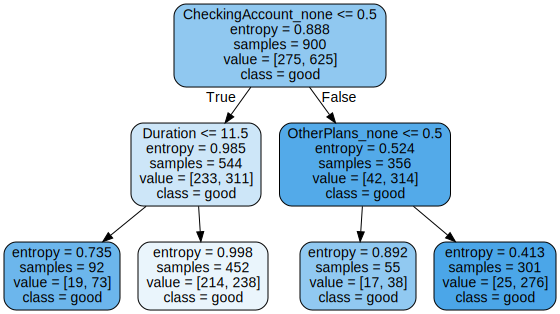

In [167]:
dot_data = export_graphviz(dt, out_file=None, 
    feature_names=one_hot_cols,  
    class_names=list(reversed(credit_clean['Approve'].unique())),  
    filled=True, rounded=True,  
    special_characters=False)
graph = graphviz.Source(dot_data)
graph

An alternative way to visualise the tree is to open the output .dot file with an editor such as [this online .dot renderer](http://dreampuf.github.io/GraphvizOnline/). You can use the code below to create a dot-file and then copy and paste its contents into the online site (you can double click on the tree once it has been produced to view it in full screen).

In [168]:
with open("tree.dot", 'w') as f:
    f = export_graphviz(dt, out_file=f,
                        feature_names=one_hot_cols,  
                        class_names=list(reversed(credit_clean['Approve'].unique())),  
                        filled=True, rounded=True,  
                        special_characters=False)

### ========== Question 1.13 ==========
Inspect the tree and
 1. describe what it shows, explaining how you interpret any one-hot encoded data
 1. indicate which is the attribute with the highest information gain.

***Your answer goes here:***

People in the dataset are split into 4 groups: "Checking Account & Duration < One year", "Checking Account & Duration >= One year", "No Checking Account & Other Plans", "No Checking Account & No Other Plans". But they're all classfied negatively, although for people with a checking account and a duration of at least a year, it's close. 

**The splits have the following information gains:**

Checking Account: 0.085

Duration: 0.031

Other Plans: 0.022

### ========== Question 1.14 ==========
Tree-based estimators (i.e. decision trees and random forests) can be used to compute feature importances. The importance of a feature is computed as the (normalized) total reduction of entropy (or other used `criterion`) brought by that feature. Find the relevant attributes of the classifier you just trained (i.e. those which are actually used in this short tree) and display feature importances along with their names.

In [169]:
for key in ["CheckingAccount_none", "Duration", "OtherPlans_none"]:
    print(key, ":", dt.feature_importances_[one_hot_cols.get_loc(key)])

CheckingAccount_none : 0.7176194261140465
Duration : 0.16073405056934223
OtherPlans_none : 0.12164652331661123


### ========== Question 1.15 ==========
Now we want to evaluate the performance of the classifier on unseen data. Use the trained model to predict the target variables for the test data set. Display the classification accuracy for both the training and test data sets. What do you observe? Are you surprised by the results?

In [170]:
print("Training:\t", accuracy_score(dt.predict(X_train), y_train))
print("Testing:\t", accuracy_score(dt.predict(X_test), y_test))

Training:	 0.6944444444444444
Testing:	 0.75


Our estimator just classfies everything as "good". So the result we got is just the baseline. We could have used a depth of 0 to achieve this, we have to do better.

#STARTHIDE#

The decision tree classifier is (probably) not overfitting. The classification accuracy is similar for training and test. The decision tree has provided a very simple way to interpret the data - splitting it into 8 bins and applying a class to each bin. Clearly this is an oversimplification: even in the training data, the leaves of the tree contain many examples of the 'incorrect' class.

#ENDHIDE

**However, the very astute will make an observation:** *Hint: Have a look at the class distribution in the dataset.*

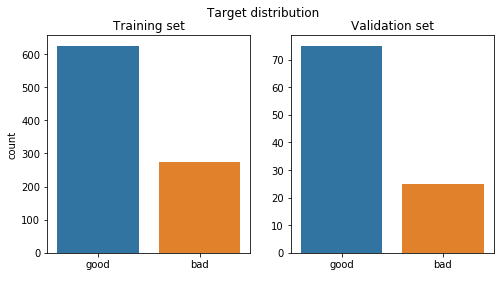

In [171]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(8,4))
sns.countplot(y_train, ax=ax1)
ax1.set_title('Training set', size=12)
ax1.set_xlabel(' ')
sns.countplot(y_test, ax=ax2)
ax2.set_xlabel(' ')
ax2.set_ylabel('')
ax2.set_title('Validation set', size=12)
fig.suptitle('Target distribution', size=12)
plt.show()

The dummy classifier of predicting everything as 'good' **will beat this model (75% accuracy on Validation Set)!** In other words, our model is worse than the baseline. **Always compare your models with very simple baselines**.

### ========== Question 1.16 ==========

Fit another `DecisionTreeClassifier` but this time grow it to full depth (i.e. remove the max_depth condition). Again, use a `random_state=1000`. Display the classification accuracy for training and test data as above. Again, what do you observe and are you surprised?

In [172]:
# Your Code goes here:
dt_deep = DecisionTreeClassifier(criterion="entropy", random_state=1000)
dt_deep.fit(X_train, y_train)
print("Training:\t", accuracy_score(dt_deep.predict(X_train), y_train))
print("Testing:\t", accuracy_score(dt_deep.predict(X_test), y_test))

Training:	 1.0
Testing:	 0.67


***Your answer goes here:***

Despite perfect accuracy on the training data (which is a given if there are no duplicates in the data), this classifier actually performs worse on the testing data than our naive baseline. I am not particularly surprised, because an unpruned decision tree classifier is bound to overfit the training data. 

### ========== Question 1.17 ==========
By using seaborn's heatmap function, plot the normalised confusion matrices for both the training and test data sets **for the max_depth=3 decision tree from question 1.12**. Make sure you label axes appropriately. *Hint: You can make use of the `plot_confusion_matrix` function introduced in a previous lab, reproduced below.*

In [173]:
def plot_confusion_matrix(cm, classes=None, title='Confusion matrix'):
    """Plots a confusion matrix."""
    if classes is not None:
        sns.heatmap(cm, xticklabels=classes, yticklabels=classes, vmin=0., vmax=1., annot=True)
    else:
        sns.heatmap(cm, vmin=0., vmax=1.)
    plt.title(title)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

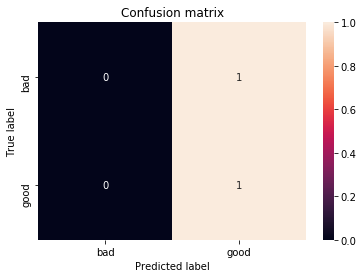

In [174]:
# Normalised Data

# Your Code goes here:
classes = list(reversed(credit_clean['Approve'].unique()))

training_totals = [len(y_train[y_train == label]) for label in classes]
norm_mat_train = np.array(training_totals * 2).reshape(2,2).transpose()

cm_train = np.divide(confusion_matrix(y_train, dt.predict(X_train)), norm_mat_train)
plot_confusion_matrix(cm_train, classes=classes)

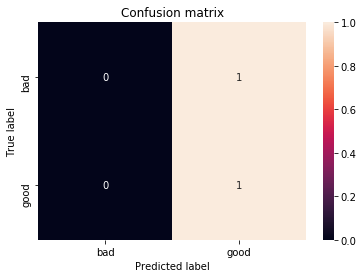

In [175]:
# Validation Data

# Your Code goes here:
testing_totals = [len(y_test[y_test == label]) for label in classes]
norm_mat_test = np.array(testing_totals * 2).reshape(2,2).transpose()

cm_test = np.divide(confusion_matrix(y_test, dt.predict(X_test)), norm_mat_test)
plot_confusion_matrix(cm_test, classes=classes)

**N.B. it will be obvious if you have plotted the full depth decision tree as the training confusion matrix will be the identity**

### ========== Question 1.18 ==========

Finally we will create a [`Random decision forest`](http://scikit-learn.org/0.19/modules/generated/sklearn.ensemble.RandomForestClassifier.html) classifier and compare the performance of this classifier to that of the decision tree. The random decision forest is an ensemble classifier that consists of many decision trees and outputs the class that is the mode of the class's output by individual trees. Start with `n_estimators = 100`, use the `entropy` criterion and the same train/test split as before. Plot the classification accuracy of the random forest model on the test set and show the confusion matrix. How does the random decision forest compare performance wise to the decision tree?

In [187]:
# Your Code goes here:
gump = RandomForestClassifier(n_estimators=100, criterion="entropy")
gump.fit(X_train, y_train)
print("Training:\t", accuracy_score(gump.predict(X_train), y_train))
print("Testing:\t", accuracy_score(gump.predict(X_test), y_test))

Training:	 1.0
Testing:	 0.74


### ========== Question 1.19 ==========
How high can you get the performance of the classifier by changing the max depth of the trees (`max_depth`), or the `max_features` parameters? Try a few values just to get a look. *Don't do a grid search or anything in-depth, just get a feel*. Try the same settings twice...do you get the same accuracy?

In [189]:
# Your Code goes here:
for depth, feats in [(3,3), (3,5), (3, 7), (3,10), (5,3), (5,5), (5, 7), (5,10), 
                     (7,3), (7,5), (7, 7), (7,10), (10,3), (10,5), (10, 7), (10,10)]:
    print("Depth:", depth, "Features:", feats)
    gump = RandomForestClassifier(n_estimators=100, criterion="entropy", max_depth=depth, max_features=feats)
    gump.fit(X_train, y_train)
    print("Training:\t", accuracy_score(gump.predict(X_train), y_train))
    print("Testing:\t", accuracy_score(gump.predict(X_test), y_test))

Depth: 3 Features: 3
Training:	 0.6944444444444444
Testing:	 0.75
Depth: 3 Features: 5
Training:	 0.6955555555555556
Testing:	 0.75
Depth: 3 Features: 7
Training:	 0.7033333333333334
Testing:	 0.75
Depth: 3 Features: 10
Training:	 0.7255555555555555
Testing:	 0.75
Depth: 5 Features: 3
Training:	 0.7144444444444444
Testing:	 0.75
Depth: 5 Features: 5
Training:	 0.7377777777777778
Testing:	 0.75
Depth: 5 Features: 7
Training:	 0.7733333333333333
Testing:	 0.74
Depth: 5 Features: 10
Training:	 0.8
Testing:	 0.72
Depth: 7 Features: 3
Training:	 0.7733333333333333
Testing:	 0.75
Depth: 7 Features: 5
Training:	 0.8244444444444444
Testing:	 0.76
Depth: 7 Features: 7
Training:	 0.8688888888888889
Testing:	 0.76
Depth: 7 Features: 10
Training:	 0.8777777777777778
Testing:	 0.72
Depth: 10 Features: 3
Training:	 0.9222222222222223
Testing:	 0.75
Depth: 10 Features: 5
Training:	 0.95
Testing:	 0.72
Depth: 10 Features: 7
Training:	 0.9522222222222222
Testing:	 0.74
Depth: 10 Features: 10
Training:	

N.B. Observing these confusion matrices you'll see something very important - for some configurations, the Random Forest **always predicts the majority class**: incidentally these are also the cases which do the best. This highlights (again) the importance of always checking performance against a dummy classifier!!!

Additionally, if you want to reproduce your results, you must set the random seed (you can do this with the `random_state` argument). Random forests are...random!

### ========== Question 1.20 ==========
Compare the feature importances as estimated with the decision tree and random forest classifiers.

In [190]:
dt.feature_importances_ - gump.feature_importances_

array([ 0.08081885, -0.0903736 , -0.06972641, -0.04814714, -0.01852313,
       -0.00560607,  0.64632518, -0.02366448, -0.01407516, -0.01152661,
       -0.01032427, -0.00899271, -0.00142148, -0.00793641, -0.01849372,
       -0.01489551, -0.00656277, -0.00891365, -0.00235955, -0.00374366,
       -0.00109626, -0.01204155, -0.02061601, -0.00653559, -0.00555099,
       -0.0063673 , -0.01472349, -0.01360042, -0.0115993 , -0.01006974,
       -0.01153553, -0.00586749, -0.00843684, -0.00962374, -0.00904713,
       -0.01460417, -0.01124276, -0.00493743, -0.00694859, -0.01129415,
       -0.0059935 , -0.00802744, -0.00846602, -0.00738265, -0.01183583,
       -0.00912358, -0.01309981, -0.0106285 , -0.01411386, -0.01083792,
       -0.01294344, -0.01382597,  0.10670594, -0.0060424 , -0.00748996,
       -0.01497983, -0.01174647, -0.01066449, -0.01094232, -0.0025737 ,
       -0.00098291, -0.01150526, -0.01115065, -0.00217624, -0.01085675,
       -0.00846606, -0.00886399, -0.01087484, -0.01089649, -0.00

In [192]:
print("0:", one_hot_cols[0])
print("6:", one_hot_cols[6])

0: Duration
6: CheckingAccount_none


It looks like all features are slightly more important for the forest, except for 2:
The importance of Duration was apparently overestimated by our initial Tree model. 
But especially whether a person has a checking account was WAY more important to our Tree than it is to our Forest.

## 2. Linear regression
In the second part of the lab we use the [CPU performance](https://archive.ics.uci.edu/ml/datasets/Computer+Hardware) dataset for a simple regression task. Famliarise yourself with the dataset before moving on to the next step. Note that the version we will be using is missing the `Model Name` and `PRP` attributes. Our task will be to use the remaining attributes to predict `ERP` values.

Download the dataset and save it in a directory called `datasets` in the same folder that your notebooks live. Alternatively, you can save the dataset in any folder you wish and modify the `data_path` variable below accordingly. We will load our data into a pandas DataFrame structure. 

In [ ]:
# Load the dataset
data_path = os.path.join(os.getcwd(), 'datasets', 'cpu.csv')
cpu = pd.read_csv(data_path, delimiter = ',')

### ========== Question 2.1 ==========
Display the number of data points and attributes in the dataset. 

In [ ]:
# Your Code goes here:

### ========== Question 2.2 ==========
Get a feeling of the data by using pandas `describe()` method. 

In [ ]:
# Your Code goes here:

### ========== Question 2.3 ==========
Display the first 10 data points of the dataset

In [ ]:
# Your Code goes here:

### ========== Question 2.4 ========== 
You might have noticed that the `vendor` attribute is categorical. This will give problems when using a linear regression model. For now we can simply remove this attribute. Create a new DataFrame called `cpu_clean` by copying `cpu` but omit the `vendor` attribute. Display the number of samples and attributes in the clean dataset as a sanity check.

In [ ]:
# Your Code goes here:

### ========== Question 2.5 ==========
Now -as always- we want to perform some exploratory data analysis. Remember that our task is to predict `ERP` values, so it's a good idea to inspect individual scatter plots of the target variable (`ERP`) against our input features. For this purpose we will use once again seaborn's pairplot implementation.

Create a series of [pairplots](https://seaborn.github.io/generated/seaborn.pairplot.html?highlight=pairplot#seaborn.pairplot) showing the pairwise relationship of `ERP` and the remaining attributes in the data. You can do so by specifying explicitly the `x_vars` and `y_vars` input arguments in the pairplot. *Hnt: Your final plot will consist of 6 subplots each contaning a scatter plot.*

In [ ]:
# Your Code goes here:

### ========== Question 2.6 ==========
* Do you think that ERP should be at least partially predictable from the input attributes?
* Do any attributes exhibit significant correlations?

***Your answer goes here:***

### ========== Question 2.7 ==========
Now we have a feel for the data and we will try fitting a simple linear regression model. Similarly to what we did in the first part of the lab, we want to use cross-validation to evaluate the goodness of the fit.

By using the `cpu_clean` dataset extract the raw values for the input features and the target variable and store them in two matrices, called `X` and `y` respectively. 

Then, split the dataset into training and testing sets by using a 75%-25% split (training/testing).

Display the shapes of all matrices involved and double-check that all dimensionalities appear to be as expected.

In [ ]:
# Your Code goes here:

### ========== Question 2.8 ==========
Fit a simple linear regressor by using the [`LinearRegression`](http://scikit-learn.org/0.19/modules/generated/sklearn.linear_model.LinearRegression.html) model in Scikit-learn. Report the training accuracy by using the `score` attribute. What does this represent?

In [ ]:
# Your Code goes here:

***Your answer goes here:***

### ========== Question 2.9 ==========
Now report the testing accuracy by using the `score` attribute of the regressor as well as the `r2_score` metric. Confirm that these two yield identical results.

How does the accuracy compare to the one reported on the training dataset? Do you think that your model does well on generalising on unseen data? 

In [ ]:
# Your Code goes here:

***Your answer goes here:***

### ========== Question 2.10 ==========
Now we want to get a feel for how good the fit is, so we wil plot the measured values against the predicted ones. Make use of the function provided below which takes as input arguments the measured (`y_true`) and predicted (`y_pred`) values of a target variable and produces a scatter plot for the two by also including a straight line going through the origin. 

Where would you expect the points to be for a perfect fit?

In [ ]:
def fit_scatter(y_true, y_pred):
    assert y_true.shape == y_pred.shape
    fig, ax = plt.subplots()
    ax.scatter(y_true, y_pred)
    ax.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'k--', lw=4)
    ax.set_xlabel('Measured')
    ax.set_ylabel('Predicted')

In [ ]:
# Your Code goes here:

***Your answer goes here:***

### ========== Question 2.11 ==========
Another way of assessing the performance of the model is to inspect the distribution of the errors. Make a histogram plot by using seaborn's `displot` function. This will also show an estimate of the underlying distribution.

Does it look like the errors are normally distributed? Would you trust the fit of the distribution on the graph? Explain why.

In [ ]:
# Your Code goes here:

***Your answer goes here:***

### ========== Question 2.12 ==========
Above we deleted the vendor variable. However, we can use nominal attributes in regression by converting them to numeric, exactly in the same way that we did at the first part of this lab. 

Now, use the original `cpu` dataset and convert the `vendor` attribute to a numeric one by means of one-hot-encoding. Then train a linear regression model to the data and compare its performance to the one we had previously. Did adding the *binazired vendor* variable help? 

In [ ]:
# Your Code goes here:

***Your answer goes here:***